To learn more about accelerating pandas on Colab, see the [10 minute guide](https://colab.research.google.com/github/rapidsai-community/showcase/blob/main/getting_started_tutorials/cudf_pandas_colab_demo.ipynb) or
 [US stock market data analysis demo](https://colab.research.google.com/github/rapidsai-community/showcase/blob/main/getting_started_tutorials/cudf_pandas_stocks_demo.ipynb).

# Grayscale to RGB with autoencoder

## Load data from Kaggle

In [368]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d anthonytherrien/dog-vs-cat


mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/anthonytherrien/dog-vs-cat
License(s): CC-BY-SA-4.0
dog-vs-cat.zip: Skipping, found more recently modified local copy (use --force to force download)


In [374]:
! unzip dog-vs-cat.zip

Archive:  dog-vs-cat.zip
  inflating: animal/cat/00000-4122619873.png  
  inflating: animal/cat/00001-4122619874.png  
  inflating: animal/cat/00002-4122619875.png  
  inflating: animal/cat/00003-4122619876.png  
  inflating: animal/cat/00004-4122619877.png  
  inflating: animal/cat/00005-4122619878.png  
  inflating: animal/cat/00006-4122619879.png  
  inflating: animal/cat/00007-4122619880.png  
  inflating: animal/cat/00008-4122619881.png  
  inflating: animal/cat/00009-4122619882.png  
  inflating: animal/cat/00010-4122619883.png  
  inflating: animal/cat/00011-4122619884.png  
  inflating: animal/cat/00012-4122619885.png  
  inflating: animal/cat/00013-4122619886.png  
  inflating: animal/cat/00014-4122619887.png  
  inflating: animal/cat/00015-4122619888.png  
  inflating: animal/cat/00016-4122619889.png  
  inflating: animal/cat/00017-4122619890.png  
  inflating: animal/cat/00018-4122619891.png  
  inflating: animal/cat/00019-4122619892.png  
  inflating: animal/cat/00020-41226

In [375]:
!pip3 install tensorflow==2.15.0 tensorflow-probability==0.23.0

In [376]:

!pip install scikit-image

In [377]:
# from PIL import Image
# import os

# directory = '/content/animal/cat'
# for filename in os.listdir(directory):
#   if filename.endswith(".jpg") or filename.endswith(".png"):
#     filepath = os.path.join(directory, filename)
#     image = Image.open(filepath)
#     image = image.resize((512, 64))
#     image.save(filepath)

## Images to Np array & Create Grayscale

In [378]:
import os
import numpy as np
from PIL import Image
from skimage import io, transform

def load_images_from_folder(folder):
    images = []
    images_names = []
    gray_images = []
    for filename in os.listdir(folder):
        if filename.endswith(('.jpg', '.png', '.jpeg')):
            img = io.imread(os.path.join(folder, filename))
            if img is not None:
                images.append(img)
                # print(img)
                gray_image = img[:,:,2]
                gray_images.append(gray_image)
                images_names.append(filename)
    return np.array(images), gray_images

train_images = load_images_from_folder('/content/animal/cat')[0]
train_images_name =  load_images_from_folder('/content/animal/cat')[1]
print(train_images.shape)

(500, 512, 512, 3)


array([[207, 209, 207, ..., 160, 161, 160],
       [206, 208, 207, ..., 161, 161, 160],
       [206, 206, 206, ..., 162, 160, 160],
       ...,
       [ 94,  97,  98, ...,  34,  34,  35],
       [ 91,  91,  91, ...,  31,  31,  30],
       [ 93,  87,  87, ...,  33,  31,  33]], dtype=uint8)
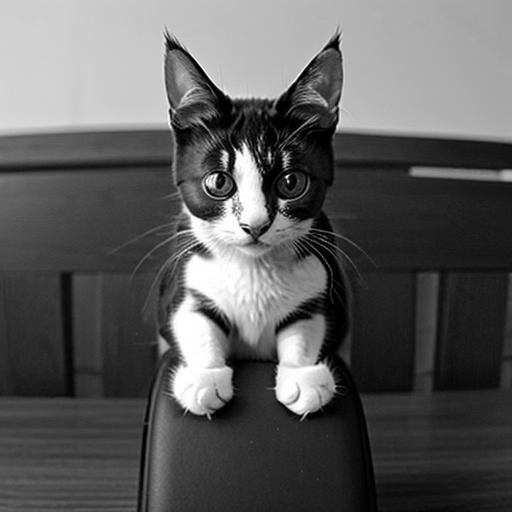

In [379]:
train_images[0][:,:,2]

In [380]:
# def to_grayscale(images):
#   gray_images = []
#   for image in images:
#     gray_img = image[:,:,2]
#     gray_images.append(gray_img)
#   return np.array(gray_images)

# gray_images = to_grayscale(train_images)
# print(gray_images.shape)


(500, 512, 512)


## Import tensorflow

In [381]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten,MaxPooling2D,UpSampling2D
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Train test split

In [384]:

X_train, X_test, y_train, y_test = train_test_split(gray_images, train_images, test_size = 0.2, random_state = 101)
# X_train, y_train, X_test, y_test = train_test_split(train_images, gray_images, train_images, gray_images)
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [385]:
y_train.shape

(400, 512, 512, 3)

## Define Nueral Network

In [402]:
input_shape = (512, 512, 1)
batch_size = 25
kernel_size = 3

### Encoder

In [403]:
inputs = Input(shape=input_shape)
x = inputs
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(filters=64, kernel_size=kernel_size, activation='relu', strides=1,padding='same',)(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(filters=64, kernel_size=kernel_size, activation='relu', strides=1,padding='same',)(x)
x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(filters=64, kernel_size=kernel_size, activation='relu', strides=1, padding='same',)(x)
# x = MaxPooling2D((2, 2), padding='same')(x)

shape = K.int_shape(x)
x = Flatten()(x)
h = Dense(1000)(x)

encoder = Model(inputs, h)

In [404]:
# inputs = Input(shape=input_shape)
# x = Conv2D(256, (3, 3), activation='relu', padding='same')(inputs)
# x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
# x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
# x = MaxPooling2D((2, 2), padding='same')(x)

In [405]:
encoder.summary()

Model: "model_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_70 (InputLayer)       [(None, 512, 512, 1)]     0         
                                                                 
 max_pooling2d_91 (MaxPooli  (None, 256, 256, 1)       0         
 ng2D)                                                           
                                                                 
 conv2d_98 (Conv2D)          (None, 256, 256, 64)      640       
                                                                 
 max_pooling2d_92 (MaxPooli  (None, 128, 128, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_99 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_93 (MaxPooli  (None, 64, 64, 64)        0  

### Decoder

In [407]:

h_inputs = Input(shape=(1000,))
x = Dense(shape[1] * shape[2] * shape[3])(h_inputs)

x = Reshape((shape[1], shape[2], shape[3]))(x)
# x = UpSampling2D((2,2))(x)
# x = Conv2DTranspose(filters=64, kernel_size=kernel_size, activation='relu', strides=1, padding='same',)(x)
x = UpSampling2D((2,2))(x)
x = Conv2DTranspose(filters=32, kernel_size=kernel_size, activation='relu', strides=1, padding='same',)(x)
x = UpSampling2D((2,2))(x)
x = Conv2DTranspose(filters=32, kernel_size=kernel_size, activation='relu', strides=1, padding='same',)(x)
x = UpSampling2D((2,2))(x)
outputs = Conv2DTranspose(filters=3, kernel_size=kernel_size, activation='sigmoid', strides=1, padding='same',)(x)

decoder = Model(h_inputs, outputs)

In [408]:
# # h_inputs = Input(shape=(100,))
# x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

In [409]:
decoder.summary()

Model: "model_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_71 (InputLayer)       [(None, 1000)]            0         
                                                                 
 dense_56 (Dense)            (None, 262144)            262406144 
                                                                 
 reshape_23 (Reshape)        (None, 64, 64, 64)        0         
                                                                 
 up_sampling2d_59 (UpSampli  (None, 128, 128, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_transpose_78 (Conv2  (None, 128, 128, 32)      18464     
 DTranspose)                                                     
                                                                 
 up_sampling2d_60 (UpSampli  (None, 256, 256, 32)      0  

In [410]:
autoencoder = Model(inputs, decoder(encoder(inputs)))
autoencoder.summary()


Model: "model_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_70 (InputLayer)       [(None, 512, 512, 1)]     0         
                                                                 
 model_74 (Functional)       (None, 1000)              262182568 
                                                                 
 model_75 (Functional)       (None, 512, 512, 3)       262434723 
                                                                 
Total params: 524617291 (1.95 GB)
Trainable params: 524617291 (1.95 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Compile and Fit

In [411]:
# autoencoder.compile(loss='mse', optimizer='adam')
from tensorflow.keras import layers, models, optimizers
autoencoder.compile(optimizer=optimizers.Adam(learning_rate=0.0005), loss ='mse')

In [412]:
X_train = X_train.reshape(400, 512, 512, 1)
X_train.shape

(400, 512, 512, 1)

In [413]:
X_test = X_test.reshape(100, 512, 512, 1)
X_test.shape

(100, 512, 512, 1)

In [414]:
X_train[0].shape

(512, 512, 1)

In [ ]:
autoencoder.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1000, batch_size=batch_size)

Epoch 1/1000
 3/16 [====>.........................] - ETA: 4s - loss: 17576.9570

### Prediction

In [ ]:
x_decoded = autoencoder.predict(X_test)

### Plot the result

In [ ]:
plt.figure()
x_test = X_test
plt.title("x_decode")
ax1 = plt.subplot(2,4,1)
ax1.title.set_text('x_decoded')
plt.imshow(x_decoded[0], cmap='gray')
plt.subplot(2,4,2)
plt.imshow(x_decoded[1], cmap='gray')
plt.subplot(2,4,3)
plt.imshow(x_decoded[2], cmap='gray')
plt.subplot(2,4,4)
plt.imshow(x_decoded[3], cmap='gray')
ax2 = plt.subplot(2,4,5)
ax2.title.set_text('x_test')
plt.imshow(x_test[0], cmap='gray')
plt.subplot(2,4,6)
plt.imshow(x_test[1], cmap='gray')
plt.subplot(2,4,7)
plt.imshow(x_test[2], cmap='gray')
plt.subplot(2,4,8)
plt.imshow(x_test[3], cmap='gray')